[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lento234/ml-tutorials/blob/main/02-advanced/image_segmentation.ipynb)

# Image segmentation

## Dataset: PASCAL Visual Object Classes (VOC)

<p>
<center>
        <table border="0" cellspacing="0" cellpadding="2">
          <tr>
            <th>Image</th><th>Object <br/>segmentation</th><th>Class <br/>segmentation</th>
            <td width="60"></td><th>Image</th><th>Object <br/>segmentation</th><th>Class <br/>segmentation</th>
          </tr>
          <tr>
            <td><a href="images/01.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/01_thumb.jpg width="120"/></a></td>
            <td><a href="images/01_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/01_object_thumb.png width="120"/></a></td>
            <td><a href="images/01_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/01_class_thumb.png width="120"/></a></td>
            <td></td>
            <td><a href="images/02.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/02.jpg width="120"/></a></td>
            <td><a href="images/02_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/02_object.png width="120"/></a></td>
            <td><a href="images/02_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/02_class_thumb.png width="120"/></a></td>
          </tr>
          <tr>
            <td><a href="images/03.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/19_thumb.jpg width="120"/></a></td>
            <td><a href="images/03_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/19_object_thumb.png width="120"/></a></td>
            <td><a href="images/03_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/19_class_thumb.png width="120"/></a></td>
            <td></td>
            <td><a href="images/04.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_thumb.jpg width="120"/></a></td>
            <td><a href="images/04_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_object_thumb.png width="120"/></a></td>
            <td><a href="images/04_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_class_thumb.png width="120"/></a></td>
          </tr>
          <tr>
            <td><a href="images/05.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/26_thumb.jpg width="120"/></a></td>
            <td><a href="images/05_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/26_object_thumb.png width="120"/></a></td>
            <td><a href="images/05_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/26_class_thumb.png width="120"/></a></td>
            <td></td>
            <td><a href="images/06.jpg"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/29_thumb.jpg width="120"/></a></td>
            <td><a href="images/06_object.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/29_object_thumb.png width="120"/></a></td>
            <td><a href="images/06_class.png"><img src=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/29_class_thumb.png width="120"/></a></td>
          </tr>
        </table>
      </center>
</p>          

<div align="center">
    <img src="http://host.robots.ox.ac.uk/pascal/VOC/voc2007/examples/bicycle_08.jpg" alt="unet" width="300"/>
    <img src="http://host.robots.ox.ac.uk/pascal/VOC/voc2007/examples/dog_08.jpg" alt="unet" width="300"/>
    <img src="http://host.robots.ox.ac.uk/pascal/VOC/voc2007/examples/aeroplane_03.jpg" alt="unet" width="300"/>
</div>

- http://host.robots.ox.ac.uk/pascal/VOC/

**Other datasets**:
- The Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/%7Evgg/data/pets/
- CamVid: Motion-based segmentation and recognition dataset: http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid
- Cityscapes dataset: https://www.cityscapes-dataset.com/

**References**:
- https://github.com/NVIDIA/semantic-segmentation
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf 

## Table of  content
1. [Load and pre-process dataset](#load)
2. [Define a CNN architecture (pre-trained)](#define)
3. [Setup the trainer](#trainer)
4. [Train the model](#train)
----

## Setup

Lightning is easy to install. Simply ```pip install pytorch-lightning```

In [1]:
!pip install pytorch-lightning --quiet

#### Download dataset

### Environment

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
pl.seed_everything(234)

Global seed set to 234


234

### Hyper-parameters

In [4]:
batch_size = 8
num_workers = 4
max_epochs = 100
learning_rate = 0.01

<a id='load'></a>
## 1. Load and pre-process dataset

- Define preprocessing algorithm
- Load training and test dataset

### 1.1 Define pre-processing steps

In [5]:
class ToTensor(transforms.ToTensor):
    def __call__(self, img, seg):
        img = transforms.functional.to_tensor(img)
        seg = torch.as_tensor(np.array(seg), dtype=torch.int64)
        return img, seg
    
class Normalize(transforms.Normalize):
    def forward(self, img, seg):
        img = transforms.functional.normalize(img, self.mean, self.std, self.inplace)
        return img, seg
    
class Compose(transforms.Compose):
    def __call__(self, img, seg):
        for t in self.transforms:
            img, seg = t(img, seg)
        return img, seg

class RandomCrop(transforms.RandomCrop):
    def forward(self, img, seg):
        if self.padding is not None:
            img = transforms.functional.pad(img, self.padding, self.fill, self.padding_mode)
            seg = transforms.functional.pad(seg, self.padding, self.fill, self.padding_mode)

        width, height = transforms.functional._get_image_size(img)
        # pad the width if needed
        if self.pad_if_needed and width < self.size[1]:
            padding = [self.size[1] - width, 0]
            img = transforms.functional.pad(img, padding, self.fill, self.padding_mode)
            seg = transforms.functional.pad(seg, padding, self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and height < self.size[0]:
            padding = [0, self.size[0] - height]
            img = transforms.functional.pad(img, padding, self.fill, self.padding_mode)
            seg = transforms.functional.pad(seg, padding, self.fill, self.padding_mode)

        i, j, h, w = self.get_params(img, self.size)

        return transforms.functional.crop(img, i, j, h, w), transforms.functional.crop(seg, i, j, h, w)
    
transform = Compose([
    ToTensor(), # convert image and seg to pytorch tensor
    RandomCrop((128, 128)),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize dataset
])

### 1.2 Load training and test dataset

In [6]:
# Download train and test dataset
train_dataset = datasets.VOCSegmentation(root='./data', year='2007',
                                         image_set='train', download=True,
                                         transforms=transform)
val_dataset = datasets.VOCSegmentation(root='./data', year='2007',
                                       image_set='val', download=True,
                                       transforms=transform)

# Dataset sampler (shuffle, distributed loading)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                         shuffle=False, num_workers=num_workers)

classes = np.array([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car' , 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
])

num_classes = len(classes)

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar


torch.Size([3, 132, 1042]) torch.Size([3, 132, 1042])


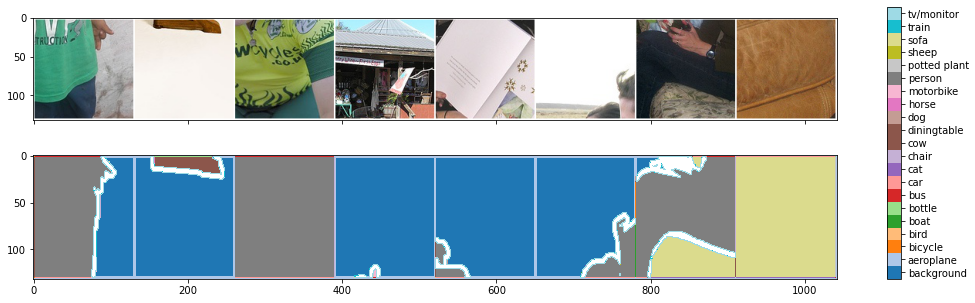

In [7]:
# Functions to show an image
def imshow(img, seg):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npseg = seg.numpy()
    print(img.shape, seg.shape)
    fig, axes = plt.subplots(2, 1, figsize=(18,5), sharex=True, sharey=True)
    axes[0].imshow(np.transpose(npimg, (1, 2, 0)))
    im = axes[1].contourf(seg[0], levels=(np.arange(len(classes)+1)-0.5), cmap='tab20')
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_ticks(np.arange(len(classes)))
    cbar.set_ticklabels(classes)
    plt.show()


# get some random training images
img, seg = next(iter(train_loader))
# show images
imshow(torchvision.utils.make_grid(img, pad_value=1),
       torchvision.utils.make_grid(seg[:,None], pad_value=1))

<a id=define></a>
## 2. Define a CNN architecture FCN - Resnet101

![network](../images/fcn_resnet101.png)

source: https://arxiv.org/pdf/1605.06211.pdf

In [8]:
class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = torchvision.models.segmentation.fcn_resnet101(*args, **kwargs)
    
    def __call__(self, *args, **kwargs):
        return self.net(*args, **kwargs)
    
    def training_step(self, batch, batch_nb):
        x_train, y_train = batch
        y_pred = self.net(x_train)
        loss = F.cross_entropy(y_pred['out'], y_train, ignore_index=255) + \
                0.5 * F.cross_entropy(y_pred['aux'], y_train, ignore_index=255)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True) # logging
        return loss
    
    def validation_step(self, batch, batch_nb):
        x_test, y_test = batch
        y_pred = self.net(x_test)
        loss = F.cross_entropy(y_pred['out'], y_test, ignore_index=255) + \
                0.5 * F.cross_entropy(y_pred['aux'], y_test, ignore_index=255)
        self.log('val_loss', loss) # logging
        return loss    
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),
                               lr=learning_rate)

In [9]:
model = Model(
    pretrained=False,
    num_classes=num_classes,
    aux_loss=True
)

# model = Model(pretrained=True, num_classes=num_classes, aux_loss=True)

<a id=trainer></a>
## 3. Setup the trainer

### 3.1 Define a logger

In [10]:
logger = pl.loggers.TensorBoardLogger(
    save_dir="lightning_logs",
    name="VOC",
    log_graph=True
)

### 3.2 Additional callbacks

In [11]:
# # checkpoint
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=3,
)

### 3.2 Initialize the trainer

In [12]:
# GPU trainer
trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=True,
    max_epochs=1,#max_epochs,
    progress_bar_refresh_rate=100,
    log_gpu_memory='all',
    logger=logger,
    callbacks=[checkpoint_callback],
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


<a id=train></a>
## 4. Train the model

In [13]:
trainer.fit(model, train_loader, val_loader)


  | Name | Type | Params
------------------------------
0 | net  | FCN  | 54.3 M
------------------------------
54.3 M    Trainable params
0         Non-trainable params
54.3 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

<a id=tensorboard></a>
## 5. Assess training with **tensorboard**

In [14]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 35420), started 0:26:22 ago. (Use '!kill 35420' to kill it.)

<a id="validate"></a>
## 5. Test the model on **test** dataset

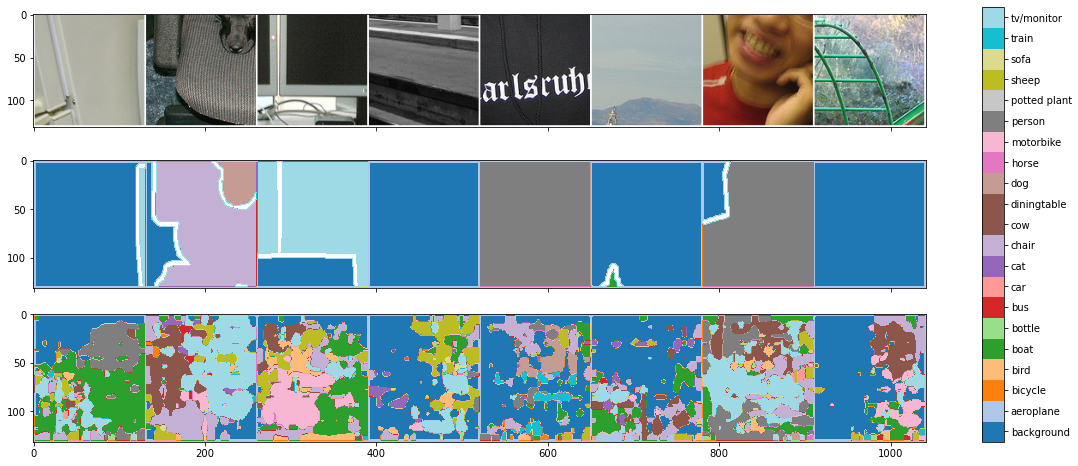

In [15]:
# Functions to show an image
def imshow(img, seg, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npseg = seg.numpy()
    nppred = pred.numpy()
    fig, axes = plt.subplots(3, 1, figsize=(20,8), sharex=True, sharey=True)
    axes[0].imshow(np.transpose(npimg, (1, 2, 0)))
    im = axes[1].contourf(seg[0], levels=(np.arange(len(classes)+1)-0.5), cmap='tab20')
    axes[2].contourf(pred[0], levels=(np.arange(len(classes)+1)-0.5), cmap='tab20')
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_ticks(np.arange(len(classes)))
    cbar.set_ticklabels(classes)
    plt.show()

model = model.cpu()
# get some random training images
img, seg = next(iter(val_loader))
pred = model(img)['out'].argmax(1)

# show images
imshow(torchvision.utils.make_grid(img, pad_value=1),
       torchvision.utils.make_grid(seg[:,None], pad_value=1),
       torchvision.utils.make_grid(pred[:,None], pad_value=1))